# Laboratorio 3 - Análisis GeoEspacial y Sensores Remotos

### Importar librerías a usar:

In [1]:
from pathlib import Path
import re
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

## Carga de imágenes:



In [2]:
IMAGES_DIR = Path("images")
OUT_DIR = Path("outputs")

Pares detectados:
 - 2020-03-05: 2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B04_(Raw).tiff | 2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B08_(Raw).tiff
 - 2024-03-09: 2024-03-09-00_00_2024-03-09-23_59_Sentinel-2_L2A_B04_(Raw).tiff | 2024-03-09-00_00_2024-03-09-23_59_Sentinel-2_L2A_B08_(Raw).tiff
Guardado: NDVI_2020-03-05.tif
Guardado: NDVI_2024-03-09.tif
Guardado: NDVI_diff_2024-03-09_minus_2020-03-05.tif
Guardado: NDVI_loss_mask_2024-03-09_minus_2020-03-05_th-0.2.tif (1 = pérdida significativa)


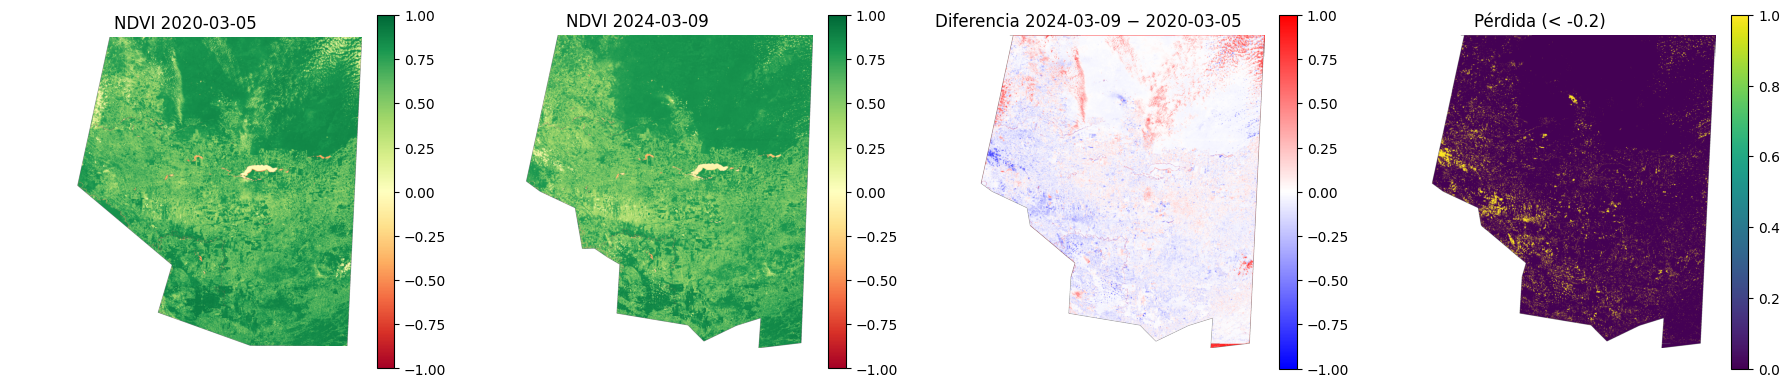

In [3]:
# ----- Detectar banda y fecha según tus nombres -----
def detect_band(p: Path):
    s = p.name.upper()
    if "B04" in s: return "red"
    if ("B08" in s or re.search(r"\bB8\b", s)) and "B8A" not in s: return "nir"
    return None

def parse_date(p: Path):
    # Toma el PRIMER YYYY-MM-DD que aparezca (en tus archivos es el día de adquisición)
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", p.name)
    if m: return m.group(1)
    m = re.search(r"(20\d{6})", p.name)
    if m:
        d = m.group(1); return f"{d[:4]}-{d[4:6]}-{d[6:]}"
    return p.stem  # último recurso

# ----- Lectura y alineación -----
def read_band_aligned(red_path: Path, nir_path: Path):
    with rasterio.open(nir_path) as dn, rasterio.open(red_path) as dr:
        nir = dn.read(1, masked=True).astype("float32")
        red = dr.read(1, masked=True).astype("float32")
        # Reproyecta RED al grid del NIR si hace falta
        if (red.shape != nir.shape) or (dr.transform != dn.transform) or (dr.crs != dn.crs):
            red_aligned = np.zeros(nir.shape, dtype="float32")
            reproject(
                source=red.filled(0),
                destination=red_aligned,
                src_transform=dr.transform, src_crs=dr.crs,
                dst_transform=dn.transform, dst_crs=dn.crs,
                resampling=Resampling.bilinear,
            )
            mask = (red_aligned == 0) | nir.mask
            red = np.ma.array(red_aligned, mask=mask)
        else:
            red.mask = red.mask | nir.mask
        return red, nir, dn.profile

def compute_ndvi(red, nir):
    denom = (nir + red)
    with np.errstate(divide="ignore", invalid="ignore"):
        ndvi = (nir - red) / denom
    bad = (denom == 0) | red.mask | nir.mask
    return np.ma.array(ndvi.astype("float32"), mask=bad)

def write_geotiff(path: Path, array_ma: np.ma.MaskedArray, ref_profile, dtype="float32", nodata_value=-9999):
    prof = ref_profile.copy()
    prof.update(driver="GTiff", dtype=dtype, count=1,
                nodata=(nodata_value if dtype!="uint8" else 0), compress="lzw")
    data = array_ma.filled(nodata_value if dtype!="uint8" else 0).astype(dtype)
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(data, 1)

# ----- Buscar y emparejar -----
tiffs = sorted(IMAGES_DIR.glob("*.tif*"))
pairs = {}
for p in tiffs:
    band = detect_band(p)
    if band is None: continue
    date = parse_date(p)
    pairs.setdefault(date, {})
    pairs[date][band] = p

pairs = {d: b for d, b in pairs.items() if "red" in b and "nir" in b}
if not pairs:
    raise RuntimeError("No hay pares B04/B08 en 'images/'. Asegúrate de que los nombres incluyan B04 y B08.")

print("Pares detectados:")
for d, b in pairs.items():
    print(f" - {d}: {b['red'].name} | {b['nir'].name}")

# ----- Calcular NDVI por fecha -----
ndvi_by_date = {}
profile_by_date = {}
for d, b in sorted(pairs.items()):
    red, nir, prof = read_band_aligned(b["red"], b["nir"])
    ndvi = compute_ndvi(red, nir)
    ndvi_by_date[d] = ndvi
    profile_by_date[d] = prof
    out_path = OUT_DIR / f"NDVI_{d}.tif"
    write_geotiff(out_path, ndvi, prof, dtype="float32", nodata_value=-9999)
    print(f"Guardado: {out_path.name}")

# ----- Si hay al menos 2 fechas, diferencia y umbral -----
fechas = sorted(ndvi_by_date.keys())
if len(fechas) >= 2:
    d0, d1 = fechas[0], fechas[-1]   # primera vs última (ej. 2020 vs 2024)
    ndvi0, ndvi1 = ndvi_by_date[d0], ndvi_by_date[d1]
    prof0, prof1 = profile_by_date[d0], profile_by_date[d1]

    # Alinear si fuera necesario
    same_grid = (prof0["crs"] == prof1["crs"]) and (prof0["transform"] == prof1["transform"]) and (ndvi0.shape == ndvi1.shape)
    if not same_grid:
        aligned = np.zeros(ndvi1.shape, dtype="float32")
        reproject(
            source=ndvi0.filled(-9999),
            destination=aligned,
            src_transform=prof0["transform"], src_crs=prof0["crs"],
            dst_transform=prof1["transform"], dst_crs=prof1["crs"],
            resampling=Resampling.bilinear,
        )
        ndvi0 = np.ma.array(aligned, mask=(aligned == -9999) | ndvi1.mask)

    ndvi_diff = np.ma.array(ndvi1 - ndvi0, mask=ndvi1.mask | ndvi0.mask)
    diff_path = OUT_DIR / f"NDVI_diff_{d1}_minus_{d0}.tif"
    write_geotiff(diff_path, ndvi_diff, profile_by_date[d1], dtype="float32", nodata_value=-9999)
    print(f"Guardado: {diff_path.name}")

    threshold = -0.2
    loss_mask = np.ma.array((ndvi_diff < threshold).astype("uint8"), mask=ndvi_diff.mask)  # 1 = pérdida
    loss_path = OUT_DIR / f"NDVI_loss_mask_{d1}_minus_{d0}_th{threshold}.tif"
    write_geotiff(loss_path, loss_mask, profile_by_date[d1], dtype="uint8")
    print(f"Guardado: {loss_path.name} (1 = pérdida significativa)")

    # ----- Visualización (dos fechas) -----
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    im0 = axs[0].imshow(ndvi_by_date[d0], vmin=-1, vmax=1, cmap="RdYlGn"); axs[0].set_title(f"NDVI {d0}"); plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    im1 = axs[1].imshow(ndvi_by_date[d1], vmin=-1, vmax=1, cmap="RdYlGn"); axs[1].set_title(f"NDVI {d1}"); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    vmax = np.nanmax(np.abs(ndvi_diff.filled(np.nan))); vmax = 0.6 if not np.isfinite(vmax) else min(max(vmax, 0.3), 1.0)
    im2 = axs[2].imshow(ndvi_diff, vmin=-vmax, vmax=vmax, cmap="bwr"); axs[2].set_title(f"Diferencia {d1} − {d0}"); plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    im3 = axs[3].imshow(loss_mask, vmin=0, vmax=1); axs[3].set_title(f"Pérdida (< -0.2)"); plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
    for ax in axs: ax.axis("off")
    plt.tight_layout(); plt.show()

else:
    # ----- Visualización (una fecha) -----
    only = fechas[0]
    print(f"\nSolo hay una fecha ({only}). Se generó NDVI; agrega otra fecha (p. ej. 2024) para calcular la diferencia y la máscara de pérdida.")
    plt.figure(figsize=(6,5))
    im = plt.imshow(ndvi_by_date[only], vmin=-1, vmax=1, cmap="RdYlGn")
    plt.title(f"NDVI {only}"); plt.axis("off"); plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
